In [1]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
# TODO get labels thats is from the return ratio, somebody do that, just a sliding window just like mvavg
import os
import pandas as pd
file_path=r'C:\Users\samri\Desktop\Code\DS\IT258-Project\saksham_data_is_here_incase_u_missed_it'
files=os.listdir(file_path)
for file in files:
    x=pd.read_csv(file_path+'/'+file)
    x['Stock Movement Label']=(x['Return Ratio'][5:]>0).astype(int)
    x.to_csv(file_path+'/'+file)

In [12]:
%pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch

from FinancialGraphAttentionmaster.model.graph_pool import SequenceEncoder as se

'''
Attentive GRU
Takes in raw week information and then makes Ai for all of the weeks for all the stocks (if bacthed)
'''

def get_Ai(week_seq_i, time_step = 5,input_size=15, hidden_size=64):
    #  Vi is the data from the week of shape (1,5,15) extra 1 is for the batch dimension
    # hi_prev is the hidden state from the previous week of shape (1,1,64)
    # TODO add a check for this if you want and to also check if week_seq_i are torch.tensors if not convert them
    
    encoder = se(input_dim=input_size, time_step=time_step, hidden_dim=hidden_size)
    ai = encoder(week_seq_i)
    
    return ai
    

In [ ]:
# TODO bacth the data into 5 days for each week and store in a structure
# each batch represents a stock and the 5 days with 15 features each ergo
# input shape should be (batch_size, 5, 15)
import pandas as pd

# Load the CSV file into a DataFrame


      Unnamed: 0       Price               Close                High  \
0              0      Ticker           360ONE.NS           360ONE.NS   
1              1        Date                 NaN                 NaN   
2              2  2020-01-10   236.8426971435547   249.8450392271116   
3              3  2020-01-13  234.19845581054688   241.1004291370887   
4              4  2020-01-14  239.17454528808594  241.51684224955795   
...          ...         ...                 ...                 ...   
1235        1235  2025-01-03  1297.1500244140625  1311.3499755859375   
1236        1236  2025-01-06  1257.9000244140625              1318.0   
1237        1237  2025-01-07   1217.300048828125  1253.3499755859375   
1238        1238  2025-01-08  1175.8499755859375  1214.8499755859375   
1239        1239  2025-01-09   1166.550048828125   1172.699951171875   

                     Low                Open     Volume         MA_5  \
0              360ONE.NS           360ONE.NS  360ONE.NS        

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# This is a test for Encoder block
batch_size = 1
time_step = 5 # Days
input_dim = 15 # Features
hidden_dim = 64 # Hidden dimension specified in the paper as {8, 16, 32, 64}
                # thats what it said this is how i interpreted it

seq = torch.randn(batch_size, time_step, input_dim)

a1 = get_Ai(seq[0].unsqueeze(0), time_step, input_dim, hidden_dim)
print(a1.shape)


torch.Size([1, 1, 64])


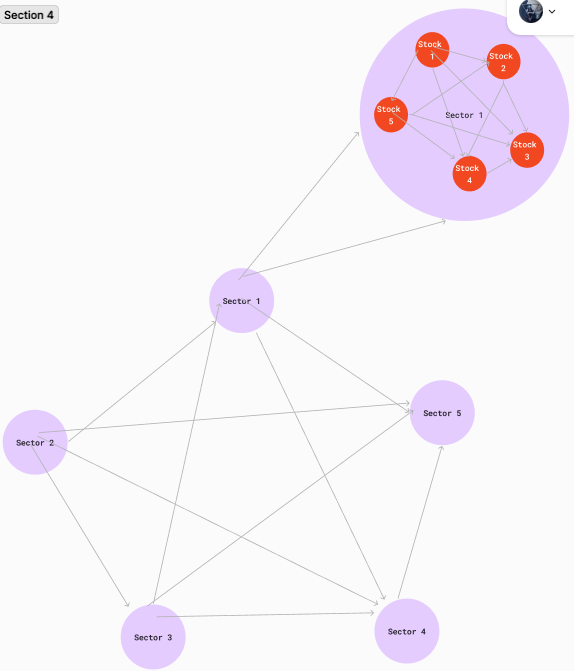

#### How the Adj Matrix looks or atleast this is what i think it looks it to my understanding a bit different from what the paper is doing, atleast thats what the GAT in the code he sent is using.

#### There are like 3 models in the repo the most basic one is used below, we should probably make this better.

In [ ]:
# TODO cluster up the same sector stocks make sure that Ai are stored in an
# adjacency matrix as specifed in the paper this is along raw Ai will be the input for GAT

from FinancialGraphAttentionmaster.model.graph_pool import CategoricalGraph as gat

def get_gi(Sq, Adj_Mat, hidden_size=64):
    # Sq is the list of the Ai for a stock
    Sq_sector_idx = Sq.sector_idx
    Sn = Adj_Mat[Sq_sector_idx]
    gat_encoder = gat(
        input_dim=15,
        time_step=10,
        hidden_dim=64,
        inner_edge=Sn,
        outer_edge=Adj_Mat,
        input_num=4,
        use_gru=True,# change to false if there is overfitting
        device=torch.device('cuda')
        )
    gi = gat_encoder(Sq, Sn)
    return gi


In [ ]:
import torch.nn as nn
class AttentionBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_step):
        super(AttentionBlock, self).__init__()
        
        # Learnable weights for the attention calculation
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim))  # Weight matrix for u
        self.V = nn.Parameter(torch.randn(hidden_dim, 1))  # Weight matrix for transformed u
        
        self.time_step = time_step  # Length of the sequence (t)
        
    def forward(self, U):
        # U: (batch_size, time_step, input_dim)  - Sequence of input vectors u_i
        
        # Apply linear transformation with weight matrix W and V, then tanh activation
        u_transformed = torch.tanh(torch.matmul(U, self.W))  # Shape: (batch_size, time_step, hidden_dim)
        
        # Compute attention scores (unnormalized) for each time step
        attention_scores = torch.matmul(u_transformed, self.V)  # Shape: (batch_size, time_step, 1)
        attention_scores = torch.squeeze(attention_scores, dim=-1)  # Shape: (batch_size, time_step)
        
        # Calculate the exponentials of the attention scores
        exp_scores = torch.exp(attention_scores)  # Shape: (batch_size, time_step)
        
        # Normalize the attention scores (softmax across the time step dimension)
        attention_weights = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)  # Shape: (batch_size, time_step)
        
        # Apply attention weights to the sequence U
        weighted_U = U * attention_weights.unsqueeze(-1)  # Shape: (batch_size, time_step, input_dim)
        
        # Output is the weighted sum of the input sequence U
        output = torch.sum(weighted_U, dim=1)  # Shape: (batch_size, input_dim)
        
        return output, attention_weights

In [ ]:
# Long-Term Sequential Learning with Short-Term Embeddings
# Input is the Ai of all stocks and Gi of all stocks
def get_T_i(Sq_ai, Sq_gi, input_dim=64, hidden_size=64, t=5):
    # Sq_ai is the list of Ai for all the stocks
    # Sq_gi is the list of Gi for all the stocks
    
    T_Ai_encoder = AttentionBlock(input_dim=input_dim, hidden_dim=hidden_size, time_step=t)
    T_Gi_encoder = AttentionBlock(input_dim=input_dim, hidden_dim=hidden_size, time_step=t)
    
    T_Ai = torch.zeros(1, hidden_size)
    T_Gi = torch.zeros(1, hidden_size)
    
    for i in range(5, len(Sq_ai)):
        # t = 5
        U_Ai = Sq_ai[i-5:i]
        U_Gi = Sq_gi[i-5:i]
        T_Ai = T_Ai_encoder(U_Ai)
        T_Gi = T_Gi_encoder(U_Gi)
    
    return T_Ai, T_Gi